## This is the softmax workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

The goal of this workbook is to give you experience with training a softmax classifier.

In [57]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '/Users/tomhagander/Documents/Neural_Networks_and_Deep_Learning/hw2_Questions/code/cifar-10-batches-py' # You need to update this line
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [59]:
from nndl import Softmax

In [60]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [61]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [62]:
print(loss)

2.327760702804897


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this make sense?

## Answer:

We are taking the negative of a sum of logarithms of numbers between zero and one, which is the same as the negative of a sum of negative numbers, which is positive. 

#### Softmax gradient

In [63]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: -1.909119 analytic: -1.909119, relative error: 3.071826e-09
numerical: 1.771418 analytic: 1.771418, relative error: 1.385187e-08
numerical: 2.009162 analytic: 2.009162, relative error: 7.222001e-12
numerical: 1.965140 analytic: 1.965140, relative error: 1.944457e-08
numerical: 1.413197 analytic: 1.413197, relative error: 5.453079e-08
numerical: 1.767842 analytic: 1.767842, relative error: 1.100799e-08
numerical: -1.151091 analytic: -1.151091, relative error: 3.563758e-08
numerical: -0.742485 analytic: -0.742485, relative error: 2.571217e-08
numerical: 0.529290 analytic: 0.529290, relative error: 2.547334e-08
numerical: -1.790853 analytic: -1.790853, relative error: 3.333724e-08


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [64]:
import time

In [65]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 2.3181612083081347 / 310.33224933553925 computed in 0.2734191417694092s
Vectorized loss / grad: 2.7603763799531524 / 310.33224933553925 computed in 0.012276887893676758s
difference in loss / grad: -0.4422151716450178 /2.8385082728302326e-13 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

iteration 0 / 1500: loss 1.823550013919184
iteration 100 / 1500: loss 2.0485088390772725
iteration 200 / 1500: loss 2.2070597788160824
iteration 300 / 1500: loss 2.82907535387603
iteration 400 / 1500: loss 2.606661690987591
iteration 500 / 1500: loss 2.6554208467299607
iteration 600 / 1500: loss 2.893889544132694
iteration 700 / 1500: loss 2.646488564574948
iteration 800 / 1500: loss 2.993724946157931
iteration 900 / 1500: loss 2.720972342269317
iteration 1000 / 1500: loss 2.453724687103486
iteration 1100 / 1500: loss 2.943478219220359
iteration 1200 / 1500: loss 3.016064401210533
iteration 1300 / 1500: loss 3.0796709219103042
iteration 1400 / 1500: loss 2.623895719555175
That took 5.373991012573242s


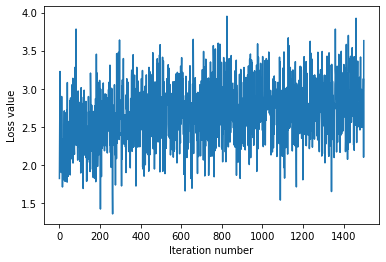

In [66]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [71]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.3811428571428571
validation accuracy: 0.398


## Optimize the softmax classifier

In [72]:
np.finfo(float).eps

2.220446049250313e-16

In [89]:
rates = 10**(np.arange(10, dtype=float) - 10)
rates = 1e-7*np.array([0.5, 1, 5, 10, 20, 50, 100])
classifiers = []
val_accuracies = []
num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

for rate in rates:
    softmax = Softmax(dims=[num_classes, num_features])
    classifiers.append(softmax)
    loss_hist = softmax.train(X_train, y_train, learning_rate=rate,
                      num_iters=1500, verbose=True)
    y_val_pred = softmax.predict(X_val)
    val_accuracies.append(np.mean(np.equal(y_val, y_val_pred)), )

print(val_accuracies)
max_index = val_accuracies.index(max(val_accuracies))
best_clf = classifiers[max_index]
y_test_pred = best_clf.predict(X_test)
print('Test accuracy: {}'.format(np.mean(np.equal(y_test, y_test_pred)), ))



iteration 0 / 1500: loss 2.3204129810902283
iteration 100 / 1500: loss 2.0342827032319812
iteration 200 / 1500: loss 2.5229470385436477
iteration 300 / 1500: loss 1.8593334192026911
iteration 400 / 1500: loss 2.9695426053083045
iteration 500 / 1500: loss 2.13123875166756
iteration 600 / 1500: loss 2.8437077230701133
iteration 700 / 1500: loss 2.4055026175166003
iteration 800 / 1500: loss 2.087800711713956
iteration 900 / 1500: loss 2.4481926137481183
iteration 1000 / 1500: loss 2.353751361417186
iteration 1100 / 1500: loss 2.66558896884974
iteration 1200 / 1500: loss 2.617627150392478
iteration 1300 / 1500: loss 2.613200758759913
iteration 1400 / 1500: loss 2.2506135702421424
iteration 0 / 1500: loss 2.814262711486462
iteration 100 / 1500: loss 2.3925088657720552
iteration 200 / 1500: loss 2.456700540052833
iteration 300 / 1500: loss 2.5462770117224367
iteration 400 / 1500: loss 2.5724220072010238
iteration 500 / 1500: loss 2.7621885394391494
iteration 600 / 1500: loss 2.10847998788827

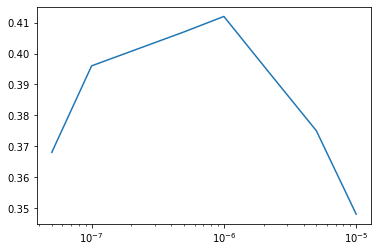

In [90]:
plt.plot(rates, val_accuracies)
plt.xscale('log')

The best learning rate is 1e-6, which yields a validation accuracy of 0.412. The testing accuracy for this learning rate is 0.381